# Spectral Reduction Exercises

Make sure to update ``bozepy`` and ``dlnpyutils``.

In [1]:
# Imports
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table,vstack
import matplotlib.colors as colors
import matplotlib
from glob import glob
from bozepy import ccdproc,spec
from scipy.signal import medfilt
from dlnpyutils import robust
import dlnpyutils.utils as dln
%matplotlib inline
# matplotlib.use('nbagg')

## Step 1. CCD Processing

<font color='blue'>
    
a) Make the master bias using the "bias.lst" list of images.
    
b) Make the master dark using the "dark.lst" list of images.
    
c) Process the rest of the science+calibration lamp images in "scical.lst".  
    
</font>

In [2]:
ls

 Volume in drive C is OS
 Volume Serial Number is 4E89-5B0C

 Directory of C:\Users\WillsPc\GitHub\ObservationalAstro_PHSX491\inclass_activities

12/15/2021  04:25 PM    <DIR>          .
12/15/2021  04:25 PM    <DIR>          ..
12/02/2021  09:30 AM    <DIR>          .ipynb_checkpoints
12/15/2021  04:22 PM    <DIR>          __pycache__
11/25/2021  01:32 AM         3,190,251 align_xmatch_photometry.ipynb
11/14/2021  12:04 AM            48,471 astroplan_exercises.ipynb
11/14/2021  12:04 AM           123,197 Astropy_Coordinates_Exercises.ipynb
11/25/2021  01:32 AM         1,198,096 Astropy_WCS_exercises.ipynb
11/14/2021  12:04 AM         9,778,135 background_detection_aperphot.ipynb
11/14/2021  12:04 AM           282,945 calibration_data.ipynb
12/02/2021  09:26 AM    <DIR>          data
12/07/2021  10:15 AM           315,035 isochrones.ipynb
11/09/2021  06:33 PM         1,961,880 isophotes_deblending.ipynb
11/14/2021  12:04 AM         3,659,456 morphology.ipynb
11/09/2021  10:37 AM       

In [3]:
# Make master bias
path = 'data/spec_reduction_exercises_data/'
bfiles = dln.readlines(path + 'bias.lst')
for i in range(len(bfiles)): bfiles[i] = path + bfiles[i]

In [4]:
bias, bhead = ccdproc.masterbias(bfiles, outfile=path + 'masterbias.fits', clobber=True, verbose=True)

Creating master bias using 5 files
1 data/spec_reduction_exercises_data/bias1.fit [4096,500]


C:\ProgramData\Anaconda3\lib\site-packages\bozepy\ccdproc.py:137: UserWarning: Image size not understood
  warnings.warn('Image size not understood')
C:\ProgramData\Anaconda3\lib\site-packages\bozepy\ccdproc.py:152: UserWarning: No TRIMSEC found in header
  warnings.warn('No TRIMSEC found in header')


2 data/spec_reduction_exercises_data/bias2.fit [4096,500]
3 data/spec_reduction_exercises_data/bias3.fit [4096,500]
4 data/spec_reduction_exercises_data/bias4.fit [4096,500]
5 data/spec_reduction_exercises_data/bias5.fit [4096,500]
Writing master bias to data/spec_reduction_exercises_data/masterbias.fits


In [5]:
# Make master dark
dfiles = dln.readlines(path + 'dark.lst')
for i in range(len(dfiles)): dfiles[i] = path + dfiles[i]

In [6]:
darks, dhead = ccdproc.masterdark(dfiles, zero=path + 'masterbias.fits', outfile=path + 'masterdark.fits', clobber=True, verbose=True)

Creating master dark using 3 files
1 data/spec_reduction_exercises_data/dark3.fit [4096,500] 600.0 sec
2 data/spec_reduction_exercises_data/dark4.fit [4096,500] 600.0 sec
3 data/spec_reduction_exercises_data/dark5.fit [4096,500] 600.0 sec
Writing master dark to data/spec_reduction_exercises_data/masterdark.fits


In [7]:
# Process the rest of the images
files = dln.readlines(path + 'scical.lst')
for i in range(len(files)): files[i] = path + files[i]

In [8]:
_, _ = ccdproc.ccdproc(files, zero= path + 'masterbias.fits', dark= path + 'masterdark.fits', outfile=True, verbose=False)

Writing processed file to data/spec_reduction_exercises_data/Ar_60s_1_red.fits
Writing processed file to data/spec_reduction_exercises_data/Ne_1s_1_red.fits
Writing processed file to data/spec_reduction_exercises_data/Quartz_2s_1_red.fits
Writing processed file to data/spec_reduction_exercises_data/Xe_60s_1_red.fits
Writing processed file to data/spec_reduction_exercises_data/alpha_peg_90sec_red.fits
Writing processed file to data/spec_reduction_exercises_data/beta_peg_60sec_red.fits
Writing processed file to data/spec_reduction_exercises_data/gamma_pisces_120sec_1_red.fits
Writing processed file to data/spec_reduction_exercises_data/nu_Anrdomeda_500sec_2_red.fits


In [9]:
rfiles=[]
for i in range(len(files)): rfiles.append(files[i][:-4] + "_red" + files[i][-4:] + 's')

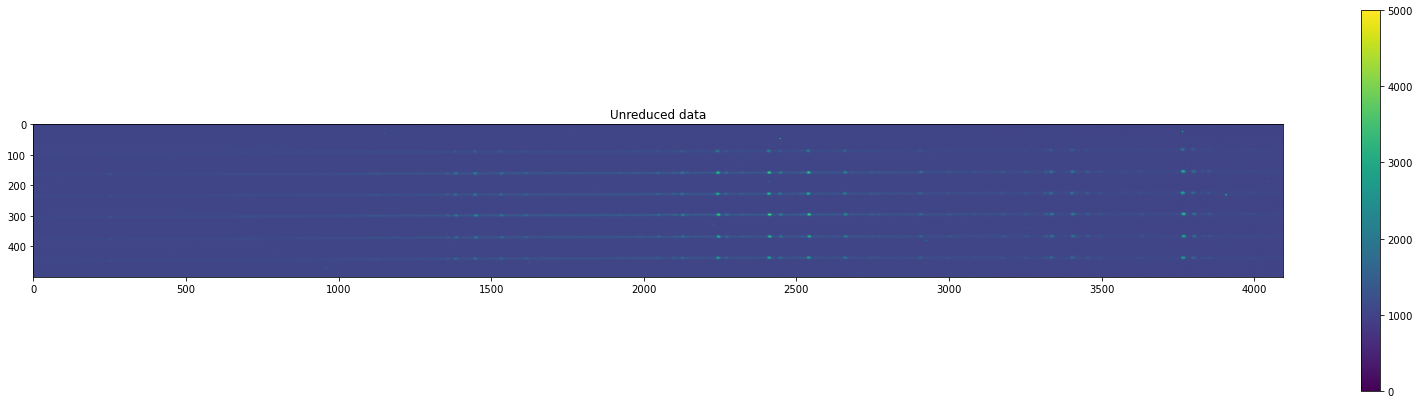

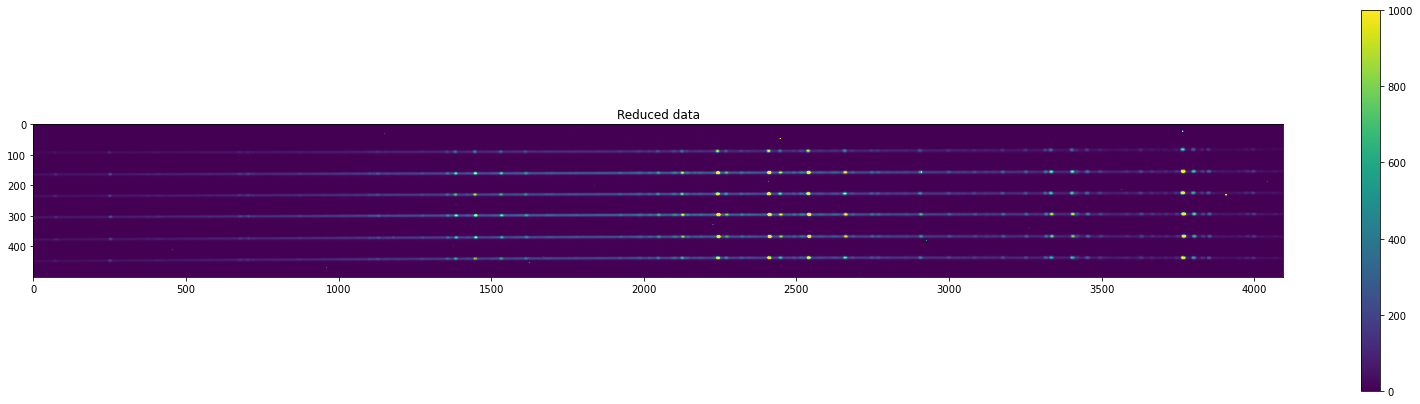

In [10]:
im, head = fits.getdata(files[0], header=True)
plt.figure(figsize=(28,7))
plt.imshow(im, vmin=0, vmax=5000)
plt.title('Unreduced data')
plt.colorbar()
plt.show()

im, head = fits.getdata(rfiles[0], header=True)
plt.figure(figsize=(28,7))
plt.imshow(im, vmin=0, vmax=1000)
plt.title('Reduced data')
plt.colorbar()
plt.show()

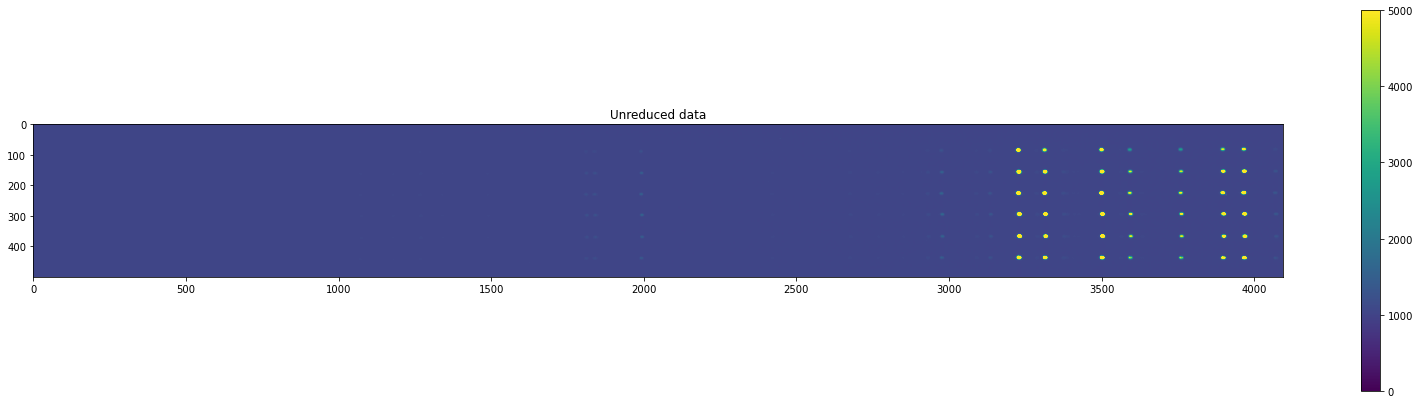

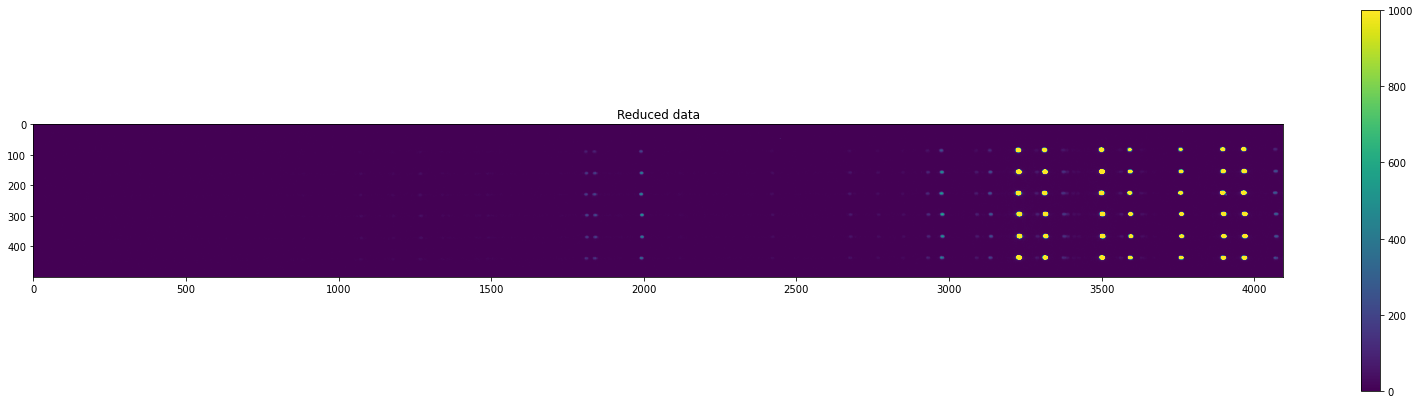

In [11]:
im, head = fits.getdata(files[1], header=True)
plt.figure(figsize=(28,7))
plt.imshow(im, vmin=0, vmax=5000)
plt.title('Unreduced data')
plt.colorbar()
plt.show()

im, head = fits.getdata(rfiles[1], header=True)
plt.figure(figsize=(28,7))
plt.imshow(im, vmin=0, vmax=1000)
plt.title('Reduced data')
plt.colorbar()
plt.show()

## Step 2. Tracing and Extraction

<font color='blue'>
    
a) Trace the Quartz spectrum (with ``spec.trace()``).  Plot the polynomial fits of ``y`` and ``sigma``.  You might want to modify ``step`` and ``yorder``.
    
b) Do a boxcar extraction of the quartz (with ``spec.boxcar()``) and plot it up.
    
c) Extract all of the science and calibration data (the scical.lst files) using the Quartz trace information and Gaussian fitting (with ``spec.extract()``) and plot the spectra.
    
</font>

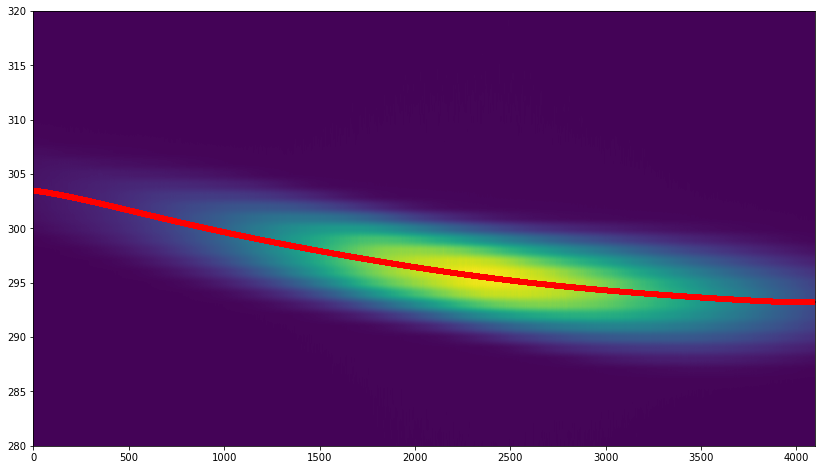

In [12]:
# Trace the spectrum, use Quartz
im = fits.getdata(path + 'Quartz_2s_1_red.fits')

tcat, ypars, sigpars, mcat = spec.trace(im, step=10, yorder=7)

fig = plt.figure(figsize=(14,8))
plt.imshow(im,origin='lower',aspect='auto')
plt.ylim(280,320)
plt.scatter(mcat['x'],mcat['y'],c='r',marker='+')

In [13]:
Table(mcat)

x,y,sigma
float64,float64,float64
0.0,303.48283348747174,2.5136795596587014
1.0,303.4804505488791,2.5144400737907313
2.0,303.47805847848366,2.515199016731999
3.0,303.4756573087408,2.5159563903230127
4.0,303.4732470720304,2.5167121964033576
5.0,303.47082780065716,2.517466436811698
6.0,303.4683995268502,2.518219113385775
7.0,303.46596228276354,2.5189702279624093
8.0,303.4635161004762,2.5197197823774977


[ 1.12129138e-23 -1.68198713e-19  1.01438794e-15 -3.15765310e-12
  5.42816754e-09 -4.58216385e-06 -2.37836185e-03  3.03482833e+02]


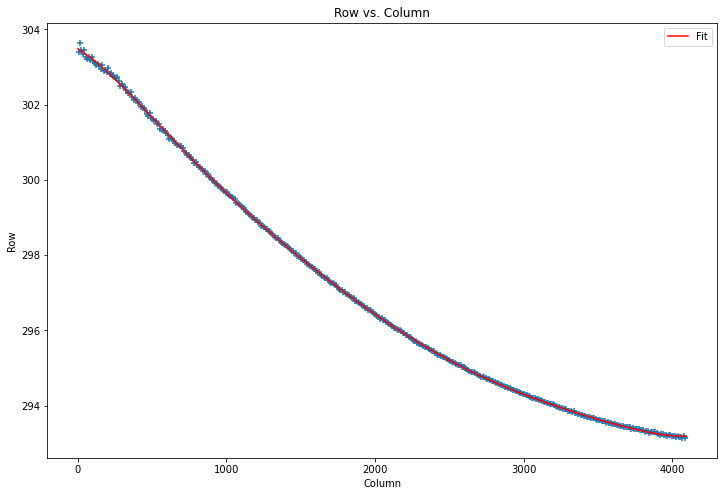

In [14]:
# Fit a polynomial to Y vs. X
fig = plt.figure(figsize=(12,8))
plt.scatter(tcat['x'],tcat['pars'][:,1],marker='+')
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Row vs. Column')
plt.plot(mcat['x'],mcat['y'],c='r',label='Fit')
plt.legend()
print(ypars)

No handles with labels found to put in legend.


[ 1.12129138e-23 -1.68198713e-19  1.01438794e-15 -3.15765310e-12
  5.42816754e-09 -4.58216385e-06 -2.37836185e-03  3.03482833e+02]


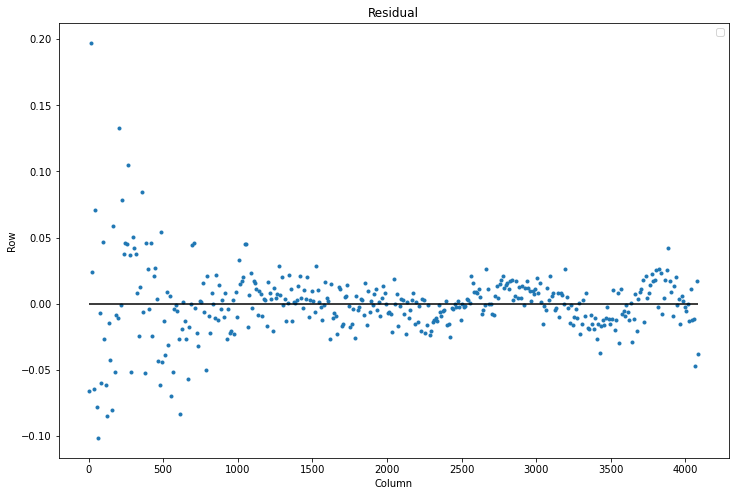

In [15]:
# Fit a polynomial to Y vs. X
fig = plt.figure(figsize=(12,8))
plt.scatter(tcat['x'],tcat['pars'][:,1] - (np.poly1d(ypars)(tcat['x'])),marker='.')
plt.xlabel('Column')
plt.ylabel('Row')
plt.title('Residual')
# plt.plot(mcat['x'],mcat['y'],c='r',label='Fit')
plt.hlines(0, np.min(tcat['x']), np.max(tcat['x']), color='black')
plt.legend()
print(ypars)

[-3.84198307e-14  3.06981840e-10 -7.86516058e-07  7.61300341e-04
  2.51367956e+00]


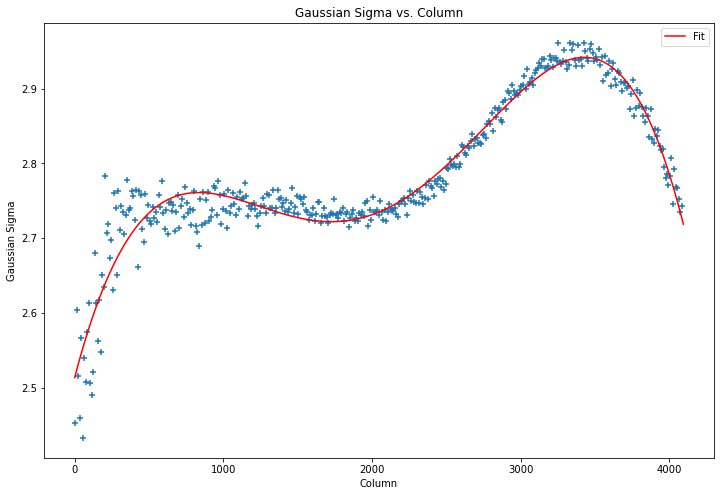

In [16]:
# Fit a polynomial to Gaussian Sigma vs. X
fig = plt.figure(figsize=(12,8))
plt.scatter(tcat['x'],tcat['pars'][:,2],marker='+')
plt.xlabel('Column')
plt.ylabel('Gaussian Sigma')
plt.title('Gaussian Sigma vs. Column')
plt.plot(mcat['x'],mcat['sigma'],c='r',label='Fit')
plt.legend()
print(sigpars)

In [17]:
# Now extract the spectrum with boxpar
box = spec.boxcar(im, ytrace=mcat['y'])
box

array([(0.000e+00, 303.48283349,  7935.5390625 , 0., 0., 0.,  7935.5390625 ),
       (1.000e+00, 303.48045055,  7818.78271484, 0., 0., 0.,  7818.78271484),
       (2.000e+00, 303.47805848,  7789.68457031, 0., 0., 0.,  7789.68457031),
       ...,
       (4.093e+03, 293.18837141, 37464.37109375, 0., 0., 0., 37464.37109375),
       (4.094e+03, 293.18844729, 37360.9765625 , 0., 0., 0., 37360.9765625 ),
       (4.095e+03, 293.18852846, 37317.484375  , 0., 0., 0., 37317.484375  )],
      dtype=[('x', '<f8'), ('ytrace', '<f8'), ('sumflux', '<f8'), ('background', '<f8'), ('backlo', '<f8'), ('backhi', '<f8'), ('flux', '<f8')])

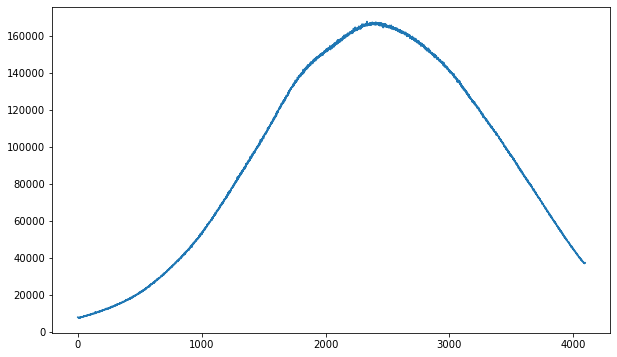

In [18]:
fig = plt.figure(figsize=(10,6))
plt.plot(box['flux'])

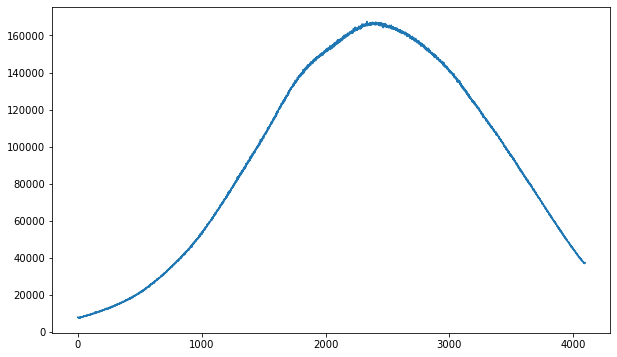

In [19]:
# Extract all of the science and calibration spectra using the same Quartz trace information
# You don't need to use nobackground=True for the arcs because these are fiber spectra

im0 = fits.getdata(rfiles[0])
box = spec.boxcar(im)
fig = plt.figure(figsize=(10,6))
plt.plot(box['flux'])

In [20]:
tcat, ypars, sigpars, mcat = spec.trace(im0, step=10, yorder=7)
im0 = fits.getdata(rfiles[0])
box = spec.boxcar(im0)
guas_box = spec.extract(im0, mcat=mcat)

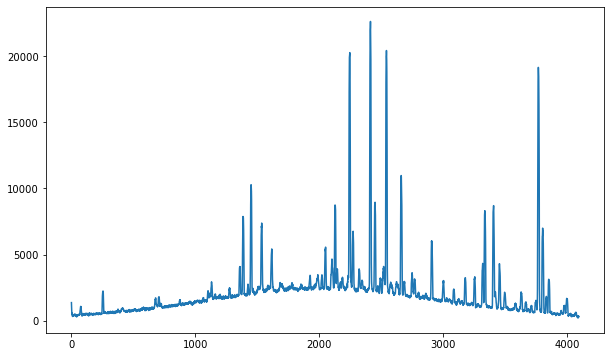

In [21]:
fig = plt.figure(figsize=(10,6))
plt.plot(guas_box['flux'])

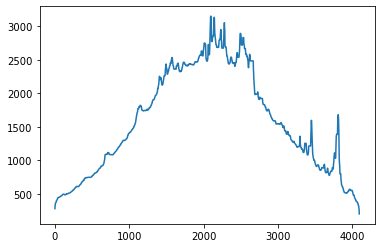

In [22]:
plt.plot(medfilt(guas_box['flux'], kernel_size=101))

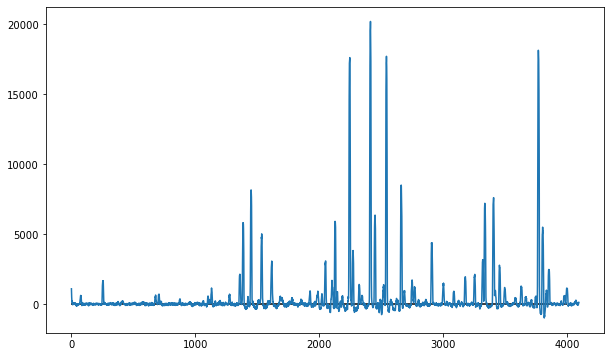

In [23]:
fig = plt.figure(figsize=(10,6))
plt.plot(guas_box['flux']-medfilt(guas_box['flux'], kernel_size=101))
plt.hlines(0, 0, 4000, color='black')

In [24]:
new_tab = Table()

Table(guas_box)['flux']
new_tab['flux1'] = Table(guas_box)['flux']
new_tab

flux1
float64
1366.204760893685
989.178335119369
813.259255149743
629.2426909268273
494.49609428933525
573.3642514937144
447.02577145409794
450.55932848956775
401.3044781289718


In [25]:
rfiles[0].split('/')[-1][:-5]

'Ar_60s_1_red'

In [26]:
guas_box['flux']-medfilt(guas_box['flux'])

array([377.02642577,   0.        ,   0.        , ..., -65.4392595 ,
        34.91293134,   0.        ])

In [27]:
flux_tab = Table()

for file in rfiles:
    tcat, ypars, sigpars, mcat = spec.trace(im0, step=10, yorder=7)
    im0 = fits.getdata(rfiles[0])
    guas_box = spec.extract(im0, mcat=mcat)
    flux_tab[file.split('/')[-1][:-5]] = guas_box['flux']-medfilt(guas_box['flux'])

## Step 3: Wavelength Solution

<font color='blue'>

We have Argon, Neon and Xenon comparison lamp spectra.  There are plots and linelists provided.  You need to use the patterns of the lines (in the figures and your extracted spectra) to identify a handful of prominent lines and then fit a polynomial to wavelength vs. column.
    
You probably want to use ``matplotlib.use('nbagg')`` to interact with the plots and find the positions.
    
a) Detect the peaks and fit Gaussians to them (using ``spec.emissionlines()``) for all three calibration lamp spectra.
    
b) Start the matching with the brightest Neon lines.  Fit an initial polynomial to the matches.
    
c) Use the initial wavelength solution to get more matches of the measured lines and the linelist using ``spec.matchlines()`` (using a matching radius of 1-2 A).  But be careful not to extrapolate it to much.
    
d)  You'll want to iterate step c until the wavelength solution improves and you have good matches across the entire spectrum.  You can also add in the Argon and Xenon lines as well.
    
    
</font>

Argon Spectrum

<img src="data/spec_reduction_exercises_data/argon_spectrum.jpeg" width=600 height=600 align="left"/>

Neon Spectrum

<img src="data/spec_reduction_exercises_data/neon1_annotated.gif" width=600 height=600 align="left"/>

Xenon Spectrum

<img src="data/spec_reduction_exercises_data/xenon_spectrum.gif" width=600 height=600 align="left"/>

Xenon-Neon Spectrum

<img src="data/spec_reduction_exercises_data/xene_spectrum.png" width=800 height=600 align="left"/>

Linelists

- argon_linelist.txt
- neon_linelist.txt
- xenon_linelist.txt

In [28]:
# Load the linelists
argon = Table.read(path + 'argon_linelist.txt',format='ascii')
neon = Table.read(path + 'neon_linelist.txt',format='ascii')
neon2 = Table.read(path + 'neon_linelist2.txt',format='ascii')  # this has itensity
xenon = Table.read(path + 'xenon_linelist.txt',format='ascii')

In [29]:
# Measure the lines in the three comparison lamp spectra using spec.emissionlines()


In [30]:
# Match the brightest Neon lines by eye.


In [31]:
# Get more matches with spec.matchlines()

In [32]:
# Iterate until you get lots of matches across the entire spectrum.

In [33]:
# Sometimes it's useful to plot the spectrum using your current best wavelength solution
#  and vertical lines for the wavelengths in the linelist
fig = plt.figure(figsize=(10,6))
# Initial wavelength solution is "wcoef"
# Extracted Neon spectrum is "nespec"
neonw0 = np.poly1d(wcoef)(nespec['x'])
nemed = medfilt(nespec['flux'],101)
plt.plot(wave,nespec['flux']-nemed+100)
for i in range(len(nelines)):
    plt.scatter(neonw0,nelines['amp'],c='r',marker='+')
# Overplot the Neon linelist lines
for i in range(len(neon)):
    plt.plot([neon['wavelength'][i],neon['wavelength'][i]],[0,100000],c='gray',alpha=0.5,linewidth=1)
plt.xlim(np.min(neonw0),np.max(neonw0))
plt.yscale('log')
plt.ylim(100,1e5)

NameError: name 'wcoef' is not defined

<Figure size 720x432 with 0 Axes>

## Step 4: Add the final wavelengths to our object spectra

In [ ]:
# Add the wavelengths to the spectrum catalog

In [ ]:
# Plot flux vs. wavelength